# Libraries and Helper Functions

In [812]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [813]:
def plot_continuous(df, column_name, bins):
    no_readmission = df[(df['READMISSION'] == False) & (df[column_name].notnull())][column_name]
    readmission = df[(df['READMISSION'] == True) & (df[column_name].notnull())][column_name]

    plt.hist(no_readmission, bins, alpha=0.5, label='No Readmission')
    plt.hist(readmission, bins, alpha=0.5, label='Readmission')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(column_name + ' by Class')
    plt.legend(loc='upper right')
    plt.show()    

In [814]:
def plot_categorical(df, column_name, width):
    no_readmission_data = [(key, value) for key, value in df[df['READMISSION'] == False][column_name].value_counts().iteritems()]
    readmission_data = [(key, value) for key, value in df[df['READMISSION'] == True][column_name].value_counts().iteritems()]
    
    ind = np.arange(len(readmission_data))
    labels = np.asarray([value[0] for value in no_readmission_data])
    
    no_readmission = np.asarray([value[1] for value in no_readmission_data])
    readmission = np.asarray([value[1] for value in readmission_data])
    
    fig, ax = plt.subplots()
    
    no_readmission_axis = ax.bar(ind, no_readmission, width)
    readmission_axis = ax.bar(ind + width, readmission, width)
    
    ax.set_ylabel('Count')
    ax.set_title(column_name + ' by Class')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)

    ax.legend((no_readmission_axis[0], readmission_axis[0]), ('No Readmission', 'Readmission'))
    
    plt.show()

In [815]:
def convert_categorical(df, column_name):
    dummy_columns = pd.get_dummies(df[column_name])
    df = pd.concat([df, dummy_columns], axis = 1)
    df = df.drop(column_name, axis = 1)
    return df

In [816]:
def adjust_years(date, decrease_factor):
    if date == date:
        year_old = date[:4]
        year_new = str(int(year_old) - decrease_factor)
        date = date.replace(year_old, year_new)
        return date
    return None

# Classify Readmission Status for Each Record

In [817]:
admissions = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/ADMISSIONS.csv')

In [818]:
print(admissions.shape)
admissions.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [819]:
# get number of records for each subject id
subject_id_counts = admissions['SUBJECT_ID'].value_counts()

# mark all subject_ids with more than one record as case for readmission
admissions['READMISSION'] = admissions['SUBJECT_ID'].apply(lambda subject_id: subject_id_counts[subject_id] > 1)

In [820]:
# Only keep the first admission and drop any records where the patient died during the initial admission
main_df = admissions.drop_duplicates('SUBJECT_ID', keep = 'first')
main_df = main_df[main_df['DEATHTIME'].isnull()]
main_df = main_df[['SUBJECT_ID', 'HADM_ID', 'READMISSION']]

In [821]:
print(main_df.shape)
main_df.head()

(42115, 3)


,SUBJECT_ID,HADM_ID,READMISSION
0,22,165315,False
1,23,152223,True
3,24,161859,False
4,25,129635,False
5,26,197661,False


In [822]:
main_df.to_csv('full_dataset.csv', index = False)

# Format Admissions Features

In [823]:
admissions = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/ADMISSIONS.csv')
columns_to_keep = ['HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
                  'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME']
admissions = admissions[columns_to_keep]
main_df = main_df.merge(admissions, how = 'left', on = 'HADM_ID')

In [824]:
print(main_df.shape)
main_df.head()

(42115, 15)


,SUBJECT_ID,HADM_ID,READMISSION,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME
0,22,165315,False,2196-04-09 12:26:00,2196-04-10 15:54:00,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00
1,23,152223,True,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN
2,24,161859,False,2139-06-06 16:14:00,2139-06-09 12:48:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN
3,25,129635,False,2160-11-02 02:06:00,2160-11-05 14:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00
4,26,197661,False,2126-05-06 15:16:00,2126-05-13 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN


#### Length of Stay

In [825]:
print("Null Values: {0}".format(main_df['ADMITTIME'].isnull().sum()))
print("Null Values: {0}".format(main_df['DISCHTIME'].isnull().sum()))
print(main_df['DISCHTIME'].max())

Null Values: 0
Null Values: 0
2206-06-10 15:59:00


In [826]:
main_df['ADMITTIME'] = main_df['ADMITTIME'].apply(lambda date: adjust_years(date, 200))
main_df['DISCHTIME'] = main_df['DISCHTIME'].apply(lambda date: adjust_years(date, 200))
main_df['ADMITTIME'] = pd.to_datetime(main_df['ADMITTIME'])
main_df['DISCHTIME'] = pd.to_datetime(main_df['DISCHTIME'])

In [827]:
main_df['DURATION_OF_STAY'] = main_df['DISCHTIME'] - main_df['ADMITTIME']
main_df['DURATION_OF_STAY'] = main_df['DURATION_OF_STAY'].dt.days * 24 + main_df['DURATION_OF_STAY'].dt.seconds * 1.0 / 3600
main_df = main_df.drop(['ADMITTIME', 'DISCHTIME'], axis = 1)

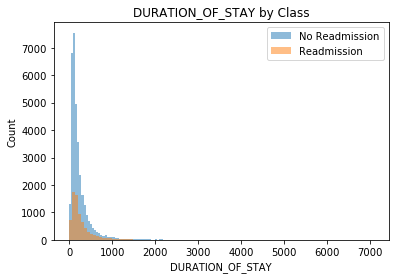

In [828]:
plot_continuous(main_df, 'DURATION_OF_STAY', 100)

#### Admission Type

In [829]:
print("Null Values: {0}".format(main_df['ADMISSION_TYPE'].isnull().sum()))
main_df['ADMISSION_TYPE'].value_counts()

Null Values: 0


EMERGENCY    27185
NEWBORN       7767
ELECTIVE      6147
URGENT        1016
Name: ADMISSION_TYPE, dtype: int64

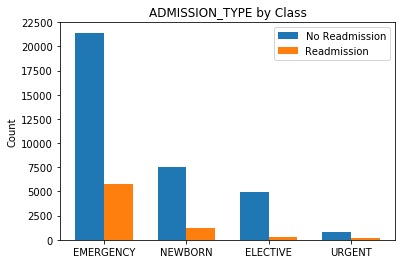

In [830]:
plot_categorical(main_df, 'ADMISSION_TYPE', 0.35)

In [831]:
main_df = convert_categorical(main_df, 'ADMISSION_TYPE')

#### Admission Location

In [832]:
print("Null Values: {0}".format(main_df['ADMISSION_LOCATION'].isnull().sum()))
main_df['ADMISSION_LOCATION'].value_counts()

Null Values: 0


EMERGENCY ROOM ADMIT         14391
PHYS REFERRAL/NORMAL DELI    12722
CLINIC REFERRAL/PREMATURE     8200
TRANSFER FROM HOSP/EXTRAM     6353
** INFO NOT AVAILABLE **       201
TRANSFER FROM SKILLED NUR      127
HMO REFERRAL/SICK               99
TRANSFER FROM OTHER HEALT       20
TRSF WITHIN THIS FACILITY        2
Name: ADMISSION_LOCATION, dtype: int64

In [833]:
# consolidate small categories
top_categories = [key for key, value in main_df['ADMISSION_LOCATION'].value_counts().iteritems() if value > 5000]
main_df['ADMISSION_LOCATION'] = main_df['ADMISSION_LOCATION'].apply(lambda x: x if x in top_categories else 'Other Admission Location')

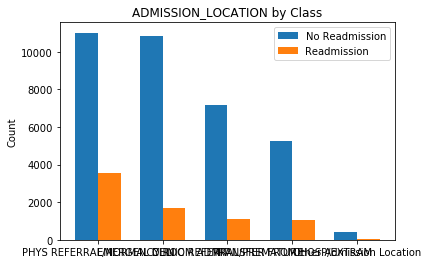

In [834]:
plot_categorical(main_df, 'ADMISSION_LOCATION', 0.35)

In [835]:
main_df = convert_categorical(main_df, 'ADMISSION_LOCATION')

#### Discharge Location

In [836]:
print("Null Values: {0}".format(main_df['DISCHARGE_LOCATION'].isnull().sum()))
main_df['DISCHARGE_LOCATION'].value_counts()

Null Values: 0


HOME                         16083
HOME HEALTH CARE             10925
SNF                           5549
REHAB/DISTINCT PART HOSP      5034
SHORT TERM HOSPITAL           1439
LONG TERM CARE HOSPITAL       1383
DISC-TRAN CANCER/CHLDRN H      587
DISCH-TRAN TO PSYCH HOSP       383
HOSPICE-HOME                   267
LEFT AGAINST MEDICAL ADVI      215
HOSPICE-MEDICAL FACILITY       116
OTHER FACILITY                  49
HOME WITH HOME IV PROVIDR       42
ICF                             31
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

In [837]:
# consolidate small categories
top_categories = [key for key, value in main_df['DISCHARGE_LOCATION'].value_counts().iteritems() if value > 100]
main_df['DISCHARGE_LOCATION'] = main_df['DISCHARGE_LOCATION'].apply(lambda x: x if x in top_categories else 'Other Discharge Location')

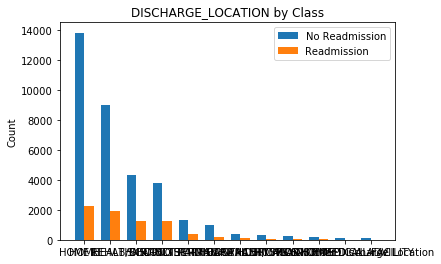

In [838]:
plot_categorical(main_df, 'DISCHARGE_LOCATION', 0.35)

In [839]:
main_df = convert_categorical(main_df, 'DISCHARGE_LOCATION')

#### Insurance

In [840]:
print("Null Values: {0}".format(main_df['INSURANCE'].isnull().sum()))
main_df['INSURANCE'].value_counts()

Null Values: 0


Private       18472
Medicare      17543
Medicaid       4132
Government     1476
Self Pay        492
Name: INSURANCE, dtype: int64

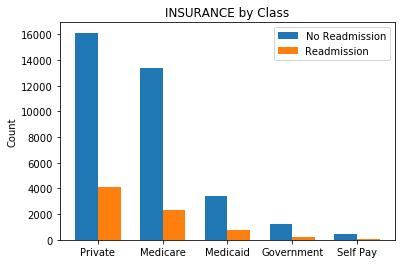

In [841]:
plot_categorical(main_df, 'INSURANCE', 0.35)

In [842]:
main_df = convert_categorical(main_df, 'INSURANCE')

#### Language

In [843]:
print("Null Values: {0}".format(main_df['LANGUAGE'].isnull().sum()))
main_df['LANGUAGE'].value_counts()

Null Values: 19877


ENGL    19215
SPAN      737
RUSS      458
PTUN      433
CANT      281
PORT      258
CAPE      185
MAND      123
HAIT       96
ITAL       74
VIET       62
GREE       44
ARAB       26
PERS       23
POLI       22
CAMB       20
KORE       19
HIND       19
AMER       19
ALBA       13
FREN       10
THAI        9
ETHI        6
SOMA        6
*BEN        6
*GUJ        5
LAOT        4
*ARM        4
*CDI        3
*BUL        3
        ...  
*TOI        2
*URD        2
*TOY        1
*PER        1
*BOS        1
*MOR        1
*TAM        1
*LIT        1
*PHI        1
** T        1
*NEP        1
*ARA        1
* FU        1
*PUN        1
* BE        1
*SPA        1
**SH        1
SERB        1
*YOR        1
*HUN        1
*KHM        1
BENG        1
*CAN        1
*AMH        1
*FIL        1
*FUL        1
**TO        1
*CRE        1
*MAN        1
*FAR        1
Name: LANGUAGE, dtype: int64

In [844]:
# consolidate all to english vs. non-english
main_df['LANGUAGE'] = main_df['LANGUAGE'].apply(lambda x: x if x == x else 'Unknown Language')
main_df['LANGUAGE'] = main_df['LANGUAGE'].apply(lambda x: x if x == 'ENGL' or x == 'Unknown Language' else 'Non-English')

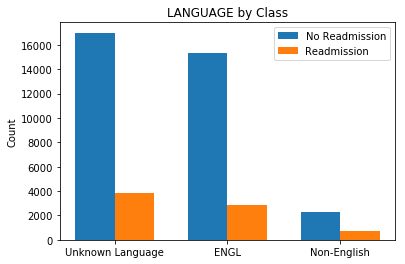

In [845]:
plot_categorical(main_df, 'LANGUAGE', 0.35)

In [846]:
main_df = main_df.drop('LANGUAGE', axis = 1)

#### Religion

In [847]:
print("Null Values: {0}".format(main_df['RELIGION'].isnull().sum()))
main_df['RELIGION'].value_counts()

Null Values: 350


CATHOLIC                  14283
NOT SPECIFIED              8854
UNOBTAINABLE               6696
PROTESTANT QUAKER          4660
JEWISH                     3383
OTHER                      1952
EPISCOPALIAN                544
CHRISTIAN SCIENTIST         336
GREEK ORTHODOX              299
BUDDHIST                    188
MUSLIM                      149
HINDU                        94
JEHOVAH'S WITNESS            92
UNITARIAN-UNIVERSALIST       91
ROMANIAN EAST. ORTH          57
7TH DAY ADVENTIST            52
BAPTIST                      17
HEBREW                       11
METHODIST                     6
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [848]:
main_df = main_df.drop('RELIGION', axis = 1)

#### Marital Status

In [849]:
print("Null Values: {0}".format(main_df['MARITAL_STATUS'].isnull().sum()))
main_df['MARITAL_STATUS'].value_counts()

Null Values: 9157


MARRIED              16676
SINGLE                8948
WIDOWED               4606
DIVORCED              2116
SEPARATED              347
UNKNOWN (DEFAULT)      254
LIFE PARTNER            11
Name: MARITAL_STATUS, dtype: int64

In [850]:
# consolidate small categories
main_df['MARITAL_STATUS'] = main_df['MARITAL_STATUS'].apply(lambda x: x if x == x else 'Unknown Marital Status')
top_categories = [key for key, value in main_df['MARITAL_STATUS'].value_counts().iteritems() if value > 2000]
main_df['MARITAL_STATUS'] = main_df['MARITAL_STATUS'].apply(lambda x: x if x in top_categories else 'Other Marital Status')

In [851]:
top_categories

['MARRIED', 'Unknown Marital Status', 'SINGLE', 'WIDOWED', 'DIVORCED']

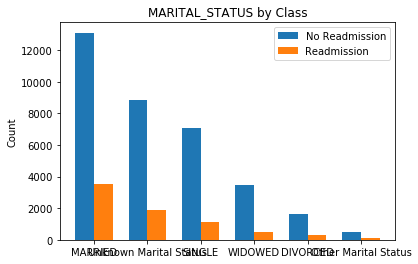

In [852]:
plot_categorical(main_df, 'MARITAL_STATUS', 0.35)

In [853]:
main_df = main_df.drop('MARITAL_STATUS', axis = 1)

#### Ethnicity

In [854]:
print("Null Values: {0}".format(main_df['ETHNICITY'].isnull().sum()))
main_df['ETHNICITY'].value_counts()

Null Values: 0


WHITE                                                       29121
UNKNOWN/NOT SPECIFIED                                        3556
BLACK/AFRICAN AMERICAN                                       3347
HISPANIC OR LATINO                                           1273
ASIAN                                                        1230
OTHER                                                        1159
UNABLE TO OBTAIN                                              637
PATIENT DECLINED TO ANSWER                                    459
ASIAN - CHINESE                                               205
BLACK/CAPE VERDEAN                                            152
HISPANIC/LATINO - PUERTO RICAN                                140
MULTI RACE ETHNICITY                                          103
WHITE - RUSSIAN                                                90
WHITE - OTHER EUROPEAN                                         65
BLACK/HAITIAN                                                  65
HISPANIC/L

In [855]:
# consolidate small categories
main_df['ETHNICITY'] = main_df['ETHNICITY'].apply(lambda x: 'UNKNOWN/NOT SPECIFIED' if x == 'UNABLE TO OBTAIN' else x)
top_categories = [key for key, value in main_df['ETHNICITY'].value_counts().iteritems() if value > 1200]
for category in top_categories:
    main_df['ETHNICITY'] = main_df['ETHNICITY'].apply(lambda x: category if category in x else x)
main_df['ETHNICITY'] = main_df['ETHNICITY'].apply(lambda x: x if x in top_categories else 'Other Ethnicity')
main_df['ETHNICITY'].value_counts()

WHITE                     29337
UNKNOWN/NOT SPECIFIED      4193
BLACK/AFRICAN AMERICAN     3347
Other Ethnicity            2383
ASIAN                      1582
HISPANIC OR LATINO         1273
Name: ETHNICITY, dtype: int64

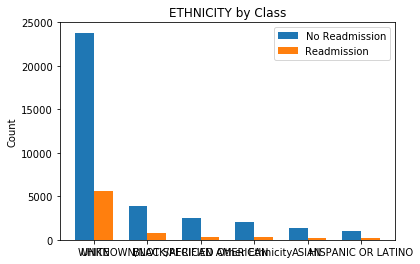

In [856]:
plot_categorical(main_df, 'ETHNICITY', 0.35)

In [857]:
main_df = convert_categorical(main_df, 'ETHNICITY')

#### Emergency Room Duration

In [858]:
print("Null Values: {0}".format(main_df['EDOUTTIME'].isnull().sum()))
print("Null Values: {0}".format(main_df['EDREGTIME'].isnull().sum()))
print(main_df['EDOUTTIME'].max())

Null Values: 22943
Null Values: 22943
2206-05-30 04:39:00


In [859]:
main_df['EDOUTTIME'] = main_df['EDOUTTIME'].apply(lambda date: adjust_years(date, 200))
main_df['EDREGTIME'] = main_df['EDREGTIME'].apply(lambda date: adjust_years(date, 200))
main_df['EDOUTTIME'] = pd.to_datetime(main_df['EDOUTTIME'])
main_df['EDREGTIME'] = pd.to_datetime(main_df['EDREGTIME'])

In [860]:
#main_df['EDOUTTIME'] = main_df['EDOUTTIME'].fillna(0)
#main_df['EDREGTIME'] = main_df['EDREGTIME'].fillna(0)
main_df['DURATION_IN_ER'] = main_df['EDOUTTIME'] - main_df['EDREGTIME']
main_df['DURATION_IN_ER'] = main_df['DURATION_IN_ER'].dt.days * 24 + main_df['DURATION_IN_ER'].dt.seconds * 1.0 / 3600
main_df = main_df.drop(['EDOUTTIME', 'EDREGTIME'], axis = 1)

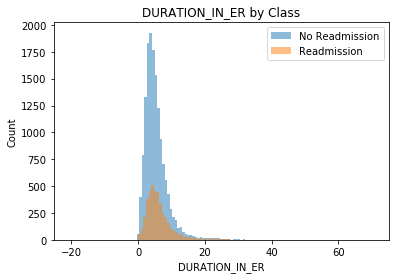

In [861]:
plot_continuous(main_df, 'DURATION_IN_ER', 100)

In [862]:
main_df['DURATION_IN_ER'] = main_df['DURATION_IN_ER'].fillna(0)

### Dataset Post Cleaning

In [863]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 37)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Medicare,Private,Self Pay,ASIAN,BLACK/AFRICAN AMERICAN,HISPANIC OR LATINO,Other Ethnicity,UNKNOWN/NOT SPECIFIED,WHITE,DURATION_IN_ER
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,3.300000
1,23,152223,True,131.916667,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.000000
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0.000000
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,3.433333
4,26,197661,False,167.733333,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0.000000


In [864]:
main_df.to_csv('full_dataset.csv', index = False)

# Format CPTEvents

In [900]:
# load cptevents and filter columns
cptevents = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/CPTEVENTS.csv')
columns_to_keep = ['HADM_ID', 'COSTCENTER', 'SECTIONHEADER', 'SUBSECTIONHEADER']
cptevents = cptevents[columns_to_keep]
print(cptevents.shape)

# filter cptevents to inlcude only those records with hadm_id in the main_df to improve processing time
sub_main = main_df[['HADM_ID', 'SUBJECT_ID']]
cptevents = cptevents.merge(sub_main, how = 'left', on = 'HADM_ID')
cptevents = cptevents[cptevents['SUBJECT_ID'].notnull()]
cptevents = cptevents.drop('SUBJECT_ID', axis = 1)
print(cptevents.shape)
cptevents.head()

(573146, 4)
(339415, 4)


,HADM_ID,COSTCENTER,SECTIONHEADER,SUBSECTIONHEADER
0,129545,ICU,Evaluation and management,Hospital inpatient services
1,129545,ICU,Evaluation and management,Hospital inpatient services
2,129545,ICU,Evaluation and management,Hospital inpatient services
3,129545,ICU,Evaluation and management,Hospital inpatient services
4,183725,ICU,Evaluation and management,Hospital inpatient services


In [901]:
def get_cpt_values(cpt_df, hadm_id, column_name, value_name):
    cpt_value = cpt_df[cpt_df['HADM_ID'] == hadm_id][column_name].value_counts()
    try:
        value = cpt_value[value_name]
    except KeyError:
        value = 0
    return value

def add_columns(df, cpt_df, column_name):
    keys = cpt_df[column_name].value_counts().keys()
    for key in keys:
        df[key] = df['HADM_ID'].apply(lambda hadm_id: get_cpt_values(cpt_df, hadm_id, column_name, key))
    return df

#### Cost Centers

In [913]:
cptevents['COSTCENTER'].value_counts()

ICU     280972
Resp     58443
Name: COSTCENTER, dtype: int64

In [914]:
main_df = add_columns(main_df, cptevents, 'COSTCENTER')

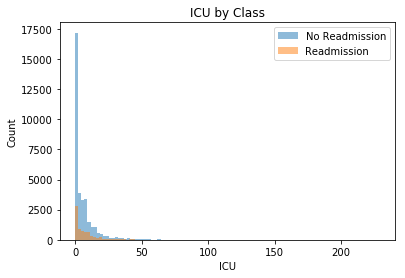

In [916]:
plot_continuous(main_df, 'ICU', 100)

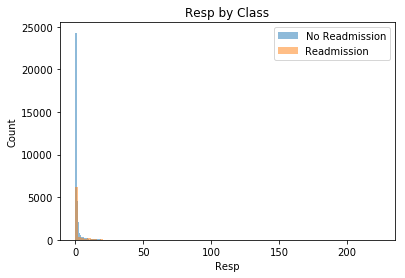

In [917]:
plot_continuous(main_df, 'Resp', 100)

#### Section Headers

In [903]:
cptevents['SECTIONHEADER'].value_counts()

Evaluation and management    236513
Medicine                      64541
Surgery                       36151
Radiology                      1657
Anesthesia                      503
Pathology and laboratory         22
Emerging technology              18
Name: SECTIONHEADER, dtype: int64

In [902]:
main_df = add_columns(main_df, cptevents, 'SECTIONHEADER')

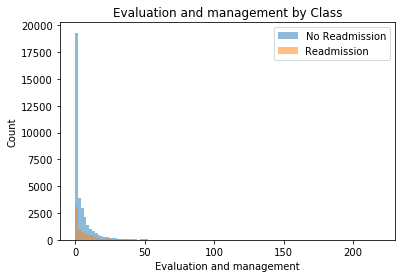

In [904]:
plot_continuous(main_df, 'Evaluation and management', 100)

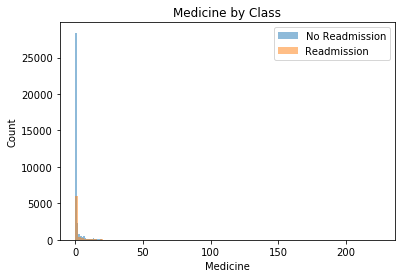

In [907]:
plot_continuous(main_df, 'Medicine', 100)

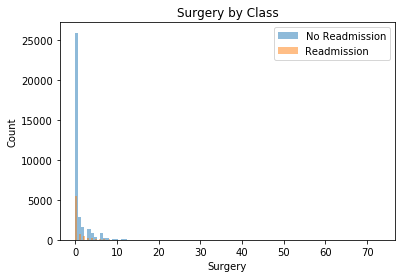

In [908]:
plot_continuous(main_df, 'Surgery', 100)

#### SubSection Headers

In [919]:
cptevents['SUBSECTIONHEADER'].value_counts()

Hospital inpatient services                          160986
Pulmonary                                             58453
Critical care services                                57414
Consultations                                         16135
Cardiovascular system                                 15875
Respiratory system                                     6172
Other Subsection Header                                5380
Musculoskeletal system                                 5098
Dialysis                                               4192
Digestive system                                       3181
Nervous system                                         2796
Integumentary system                                   1434
Follow-up inpatient consultations (deleted codes)      1223
Diagnostic ultrasound                                  1076
Name: SUBSECTIONHEADER, dtype: int64

In [918]:
top_categories = [key for key, value in cptevents['SUBSECTIONHEADER'].value_counts().iteritems() if value > 1000]
cptevents['SUBSECTIONHEADER'] = cptevents['SUBSECTIONHEADER'].apply(lambda x: x if x in top_categories else 'Other Subsection Header')

In [920]:
main_df = add_columns(main_df, cptevents, 'SUBSECTIONHEADER')

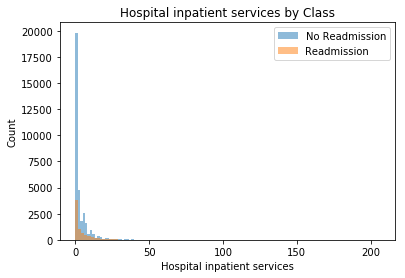

In [921]:
plot_continuous(main_df, 'Hospital inpatient services', 100)

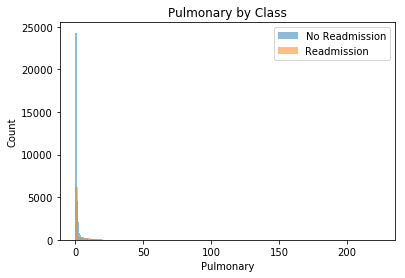

In [922]:
plot_continuous(main_df, 'Pulmonary', 100)

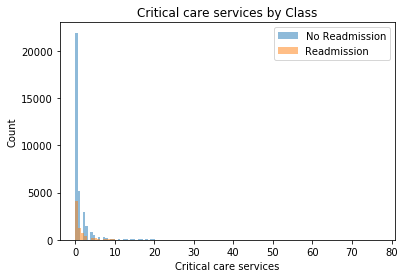

In [923]:
plot_continuous(main_df, 'Critical care services', 100)

### Dataset Post Cleaning

In [928]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 60)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Cardiovascular system,Respiratory system,Other Subsection Header,Musculoskeletal system,Dialysis,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [929]:
main_df.to_csv('full_dataset.csv', index = False)

# Format Chart Events

In [957]:
chartevents = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/chartevents_summary.csv', sep = '|')
chartevents = chartevents.iloc[1:-1]
chartevents = chartevents.rename(columns = {' hadm_id ':'HADM_ID', ' chart_count ': 'Chart_Count'})
chartevents['HADM_ID'] = chartevents['HADM_ID'].apply(lambda x: int(x)) 
print(chartevents.shape)
chartevents.head()

(57272, 2)


,HADM_ID,Chart_Count
1,185131,1090.0
2,144019,3498.0
3,164444,21871.0
4,187342,32.0
5,190267,46208.0


In [958]:
main_df = main_df.merge(chartevents, how = 'left', on = 'HADM_ID')
print(main_df.shape)
main_df.head()

(42115, 61)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Respiratory system,Other Subsection Header,Musculoskeletal system,Dialysis,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,412.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2306.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,514.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3840.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1713.0


Null Values: 891


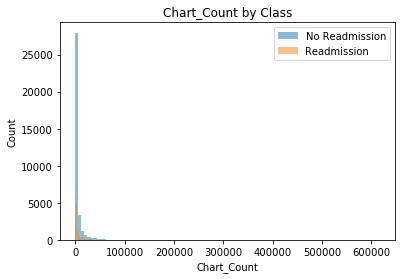

In [1153]:
print("Null Values: {0}".format(main_df['Chart_Count'].isnull().sum()))
main_df['Chart_Count'] = main_df['Chart_Count'].fillna(0)
plot_continuous(main_df, 'Chart_Count', 100)

### Dataset Post Cleaning

In [960]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 61)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Respiratory system,Other Subsection Header,Musculoskeletal system,Dialysis,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,412.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2306.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,514.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3840.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1713.0


In [961]:
main_df.to_csv('full_dataset.csv', index = False)

# Format DRG

In [1062]:
# load drg and filter columns
drg = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/DRGCODES.csv')
drg = drg[drg['DRG_TYPE'] == 'APR ']
drg = drg.drop_duplicates('HADM_ID')
columns_to_keep = ['HADM_ID','DESCRIPTION', 'DRG_SEVERITY', 'DRG_MORTALITY']
drg = drg[columns_to_keep]

# merge drg and main_df
main_df = main_df.merge(drg, how = 'left', on = 'HADM_ID')
print(main_df.shape)
main_df.head()

(42115, 64)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Dialysis,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,0,412.0,NaN,NaN,NaN
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,0,2306.0,NaN,NaN,NaN
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,0,514.0,NaN,NaN,NaN
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,0,3840.0,NaN,NaN,NaN
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,0,1713.0,NaN,NaN,NaN


#### DRG Severity

In [1063]:
print("Null Values: {0}".format(main_df['DRG_SEVERITY'].isnull().sum()))
main_df['DRG_SEVERITY'].value_counts()

Null Values: 15331


3.0    9663
2.0    7501
4.0    6852
1.0    2767
0.0       1
Name: DRG_SEVERITY, dtype: int64

In [1064]:
main_df['DRG_SEVERITY'] = main_df['DRG_SEVERITY'].apply(lambda x: 1 if x < 2 or x != x else x) 

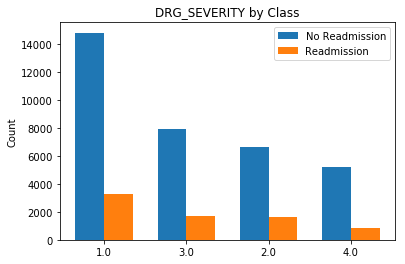

In [1065]:
plot_categorical(main_df, 'DRG_SEVERITY', .35)

#### DRG Mortality

In [1066]:
print("Null Values: {0}".format(main_df['DRG_MORTALITY'].isnull().sum()))
main_df['DRG_MORTALITY'].value_counts()

Null Values: 15331


1.0    7775
3.0    6735
2.0    6648
4.0    5625
0.0       1
Name: DRG_MORTALITY, dtype: int64

In [1067]:
main_df['DRG_MORTALITY'] = main_df['DRG_MORTALITY'].apply(lambda x: 1 if x < 2 or x != x else x) 

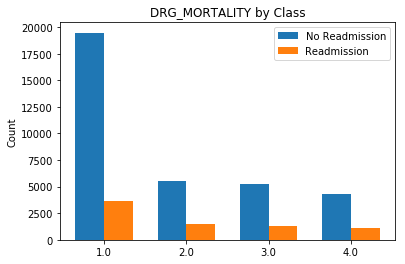

In [1068]:
plot_categorical(main_df, 'DRG_MORTALITY', .35)

#### DRG Description

In [1069]:
print("Null Values: {0}".format(main_df['DESCRIPTION'].isnull().sum()))

Null Values: 15332


Text Analysis will occur separately

### Dataset Post Cleaning

In [1070]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 64)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Dialysis,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,0,412.0,NaN,1.0,1.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,0,2306.0,NaN,1.0,1.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,0,514.0,NaN,1.0,1.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,0,3840.0,NaN,1.0,1.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,0,1713.0,NaN,1.0,1.0


In [1071]:
main_df.to_csv('full_dataset.csv', index = False)

# Format ICU Stays

In [1127]:
# read and clean ICU stay data
icu_stay = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/icustays_summary.csv', sep = '|')
icu_stay = icu_stay.iloc[1:-1]
icu_stay = icu_stay.rename(columns = {' hadm_id ':'HADM_ID', ' icu_los  ': 'ICU-LOS'})
icu_stay['HADM_ID'] = icu_stay['HADM_ID'].apply(lambda x: int(x))
icu_stay['ICU-LOS'] = icu_stay['ICU-LOS'].apply(lambda x: 0 if x == '         ' else float(x))

# merge icu stay with main_df
main_df = main_df.merge(icu_stay, how = 'left', on = 'HADM_ID')
print(main_df.shape)
main_df.head()

(42115, 65)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,412.0,NaN,1.0,1.0,1.1438
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,2306.0,NaN,1.0,1.0,1.2641
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,514.0,NaN,1.0,1.0,0.5124
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,3840.0,NaN,1.0,1.0,3.5466
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,1713.0,NaN,1.0,1.0,2.1407


Null Values: 598


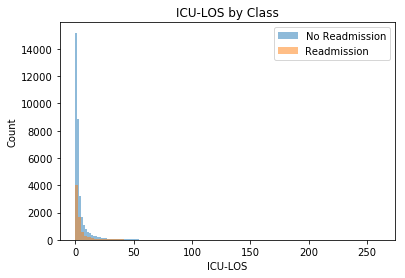

In [1151]:
print("Null Values: {0}".format(main_df['ICU-LOS'].isnull().sum()))
main_df['ICU-LOS'] = main_df['ICU-LOS'].fillna(0)
plot_continuous(main_df, 'ICU-LOS', 100)

### Dataset Post Cleaning

In [1129]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 65)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Digestive system,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,0,412.0,NaN,1.0,1.0,1.1438
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,0,2306.0,NaN,1.0,1.0,1.2641
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,0,514.0,NaN,1.0,1.0,0.5124
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,0,3840.0,NaN,1.0,1.0,3.5466
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,0,1713.0,NaN,1.0,1.0,2.1407


In [1130]:
main_df.to_csv('full_dataset.csv', index = False)

# Format Input Events

In [1156]:
# get cv input events
outputevents = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/outputevents_summary.csv', sep = '|')
outputevents = outputevents.iloc[1:-1]
outputevents = outputevents.rename(columns = {' hadm_id ':'HADM_ID', ' input_event_count ': 'Input_Event_Count_cv'})
outputevents = outputevents[outputevents['HADM_ID'] != '         ']
outputevents['HADM_ID'] = outputevents['HADM_ID'].apply(lambda x: int(x))

# get mv input events
inputevents_mv = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/inputevents_mv_summary.csv', sep = '|')
inputevents_mv = inputevents_mv.iloc[1:-1]
inputevents_mv = inputevents_mv.rename(columns = {' hadm_id ':'HADM_ID', ' input_event_count ': 'Input_Event_Count_mv'})
inputevents_mv = inputevents_mv[inputevents_mv['HADM_ID'] != '         ']
inputevents_mv['HADM_ID'] = inputevents_mv['HADM_ID'].apply(lambda x: int(x))

# combine input events
inputevents = outputevents.merge(inputevents_mv, how = 'outer', on = 'HADM_ID')
inputevents = inputevents.fillna(0)
inputevents['Input_Event_Count'] = inputevents['Input_Event_Count_cv'] + inputevents['Input_Event_Count_mv']
inputevents = inputevents.drop(['Input_Event_Count_cv','Input_Event_Count_mv'], axis = 1)

# merge input events with main_df
main_df = main_df.merge(inputevents, how = 'left', on = 'HADM_ID')
print(main_df.shape)
main_df.head()

(42115, 66)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS,Input_Event_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,412.0,NaN,1.0,1.0,1.1438,6.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,2306.0,NaN,1.0,1.0,1.2641,180.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,514.0,NaN,1.0,1.0,0.5124,50.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,3840.0,NaN,1.0,1.0,3.5466,483.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,1713.0,NaN,1.0,1.0,2.1407,49.0


Null Values: 4205


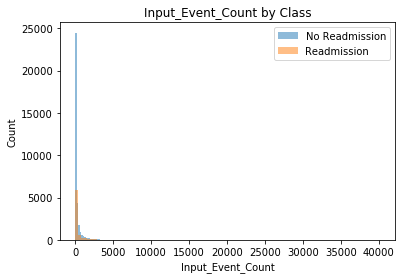

In [1157]:
print("Null Values: {0}".format(main_df['Input_Event_Count'].isnull().sum()))
main_df['Input_Event_Count'] = main_df['Input_Event_Count'].fillna(0)
plot_continuous(main_df, 'Input_Event_Count', 100)

### Dataset Post Cleaning

In [1158]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 66)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Nervous system,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS,Input_Event_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,0,412.0,NaN,1.0,1.0,1.1438,6.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,0,2306.0,NaN,1.0,1.0,1.2641,180.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,0,514.0,NaN,1.0,1.0,0.5124,50.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,0,3840.0,NaN,1.0,1.0,3.5466,483.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,0,1713.0,NaN,1.0,1.0,2.1407,49.0


In [1159]:
main_df.to_csv('full_dataset.csv', index = False)

# Format Output Events

In [1165]:
# get output events
outputevents = pd.read_csv('../mimic-code/buildmimic/postgres/mimic-data/outputevents_summary.csv', sep = '|')
outputevents = outputevents.iloc[1:-1]
outputevents = outputevents.rename(columns = {' hadm_id ':'HADM_ID', ' output_event_count ': 'Output_Event_Count'})
outputevents = outputevents[outputevents['HADM_ID'] != '         ']
outputevents['HADM_ID'] = outputevents['HADM_ID'].apply(lambda x: int(x))

# merge output events with main_df
main_df = main_df.merge(outputevents, how = 'left', on = 'HADM_ID')
print(main_df.shape)
main_df.head()

(42115, 67)


,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS,Input_Event_Count,Output_Event_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,412.0,NaN,1.0,1.0,1.1438,6.0,7.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,2306.0,NaN,1.0,1.0,1.2641,180.0,62.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,514.0,NaN,1.0,1.0,0.5124,50.0,2.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,3840.0,NaN,1.0,1.0,3.5466,483.0,59.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,1713.0,NaN,1.0,1.0,2.1407,49.0,15.0


Null Values: 5402


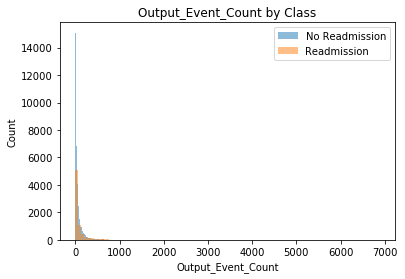

In [1166]:
print("Null Values: {0}".format(main_df['Output_Event_Count'].isnull().sum()))
main_df['Output_Event_Count'] = main_df['Output_Event_Count'].fillna(0)
plot_continuous(main_df,'Output_Event_Count', 100)

### Dataset Post Cleaning

In [1167]:
print(main_df.shape)
for column in main_df.columns:
    print column
main_df.head()

(42115, 67)
SUBJECT_ID
HADM_ID
READMISSION
DURATION_OF_STAY
ELECTIVE
EMERGENCY
NEWBORN
URGENT
CLINIC REFERRAL/PREMATURE
EMERGENCY ROOM ADMIT
Other Admission Location
PHYS REFERRAL/NORMAL DELI
TRANSFER FROM HOSP/EXTRAM
DISC-TRAN CANCER/CHLDRN H
DISCH-TRAN TO PSYCH HOSP
HOME
HOME HEALTH CARE
HOSPICE-HOME
HOSPICE-MEDICAL FACILITY
LEFT AGAINST MEDICAL ADVI
LONG TERM CARE HOSPITAL
Other Discharge Location
REHAB/DISTINCT PART HOSP
SHORT TERM HOSPITAL
SNF
Government
Medicaid
Medicare
Private
Self Pay
ASIAN
BLACK/AFRICAN AMERICAN
HISPANIC OR LATINO
Other Ethnicity
UNKNOWN/NOT SPECIFIED
WHITE
DURATION_IN_ER
Evaluation and management
Medicine
Surgery
Radiology
Anesthesia
Pathology and laboratory
Emerging technology
ICU
Resp
Hospital inpatient services
Pulmonary
Critical care services
Consultations
Cardiovascular system
Respiratory system
Other Subsection Header
Musculoskeletal system
Dialysis
Digestive system
Nervous system
Integumentary system
Follow-up inpatient consultations (deleted codes)
D

,SUBJECT_ID,HADM_ID,READMISSION,DURATION_OF_STAY,ELECTIVE,EMERGENCY,NEWBORN,URGENT,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,...,Integumentary system,Follow-up inpatient consultations (deleted codes),Diagnostic ultrasound,Chart_Count,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY,ICU-LOS,Input_Event_Count,Output_Event_Count
0,22,165315,False,27.466667,0,1,0,0,0,1,...,0,0,0,412.0,NaN,1.0,1.0,1.1438,6.0,7.0
1,23,152223,True,131.916667,1,0,0,0,0,0,...,0,0,0,2306.0,NaN,1.0,1.0,1.2641,180.0,62.0
2,24,161859,False,68.566667,0,1,0,0,0,0,...,0,0,0,514.0,NaN,1.0,1.0,0.5124,50.0,2.0
3,25,129635,False,84.816667,0,1,0,0,0,1,...,0,0,0,3840.0,NaN,1.0,1.0,3.5466,483.0,59.0
4,26,197661,False,167.733333,0,1,0,0,0,0,...,0,0,0,1713.0,NaN,1.0,1.0,2.1407,49.0,15.0


In [1168]:
main_df.to_csv('full_dataset.csv', index = False)